 ## Amazon Reviews - Sentiment Analysis

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import gzip
from string import punctuation

# natural language kit 
from nltk.corpus import stopwords
from nltk import word_tokenize

# graphing libraries
import matplotlib.pyplot as plt

# scikit learn libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, confusion_matrix


# save the model into python object structure
import pickle

 ## Data Cleanup

In [2]:
# parse json file into pandas dataframe
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/Users/nithinsivakumar/projects/ubicomp/Dataset/reviews_Beauty_5.json.gz')

In [3]:
# print first 5 rows
df.head()
df['reviewText'][0]

'Very oily and creamy. Not at all what I expected... ordered this to try to highlight and contour and it just looked awful!!! Plus, took FOREVER to arrive.'

In [4]:
# data cleaning
df['reviewText'] = df['reviewText'].str.lower()
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",very oily and creamy. not at all what i expect...,1.0,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",this palette was a decent price and i was look...,3.0,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",the texture of this concealer pallet is fantas...,4.0,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",i really can't tell what exactly this thing is...,2.0,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","it was a little smaller than i expected, but t...",3.0,It's okay.,1382140800,"10 19, 2013"


In [5]:
# remove punctuations
def remove_punctuations(text):
    for punct in punctuation:
        text = text.replace(punct, ' ')
    return text

In [6]:
# remove punctuations, stopwords
df['reviewText'] = df['reviewText'].apply(remove_punctuations)
# remove stopwords
stop = stopwords.words('english')
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",oily creamy expected ordered try highlight con...,1.0,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",palette decent price looking different shades ...,3.0,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",texture concealer pallet fantastic great cover...,4.0,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",really tell exactly thing powder kind oil ish ...,2.0,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]",little smaller expected okay lasted long time ...,3.0,It's okay.,1382140800,"10 19, 2013"


In [7]:
# creating a tokenized column and for the reviewText
df['reviewText_tok'] = df['reviewText'].apply(word_tokenize)

# creating a positive negative column where positive review (4-5) are 1 and negative reviews (1-3) are 0.
df['pos_neg'] = df['overall'].apply(lambda x: 1 if x > 3 else 0)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewText_tok,pos_neg
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",oily creamy expected ordered try highlight con...,1.0,Don't waste your money,1391040000,"01 30, 2014","[oily, creamy, expected, ordered, try, highlig...",0
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",palette decent price looking different shades ...,3.0,OK Palette!,1397779200,"04 18, 2014","[palette, decent, price, looking, different, s...",0
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",texture concealer pallet fantastic great cover...,4.0,great quality,1378425600,"09 6, 2013","[texture, concealer, pallet, fantastic, great,...",1
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",really tell exactly thing powder kind oil ish ...,2.0,Do not work on my face,1386460800,"12 8, 2013","[really, tell, exactly, thing, powder, kind, o...",0
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]",little smaller expected okay lasted long time ...,3.0,It's okay.,1382140800,"10 19, 2013","[little, smaller, expected, okay, lasted, long...",0


In [8]:
# print positve and negative reviews stats
no_tot_reviews = len(df.pos_neg)
no_pos_reviews = df.pos_neg.sum()
percent_pos_reviews = no_pos_reviews/no_tot_reviews*100
no_neg_reviews = no_tot_reviews - no_pos_reviews
percent_neg_revies = no_neg_reviews/no_tot_reviews*100

print('Number of overall reviews: ', no_tot_reviews)
print()

print('Number of positive reviews: ', no_pos_reviews)
print('Percent of Positve reviews: ',percent_pos_reviews)
print()

print('Number of negative reviews: ', no_neg_reviews)
print('Percent of reviews: ', percent_neg_revies)
print('Number of unique reviewers: ', len(set(df.reviewerID)))

Number of overall reviews:  198502

Number of positive reviews:  154272
Percent of Positve reviews:  77.71810863366616

Number of negative reviews:  44230
Percent of reviews:  22.281891366333838
Number of unique reviewers:  22363


In [9]:
# Average Length of reviews
length = []
for review in df.reviewText_tok:
    length.append(len(review))
print('Average Length of Reviews: ', np.mean(length))

Average Length of Reviews:  44.11859326354394


In [10]:
max(length)

2073

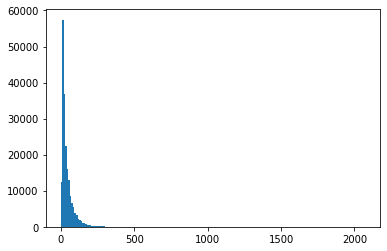

In [11]:
plt.hist(length, bins=200);

In [12]:
pos_reviews = df[df.pos_neg == 1]
pos_reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewText_tok,pos_neg
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",texture concealer pallet fantastic great cover...,4.0,great quality,1378425600,"09 6, 2013","[texture, concealer, pallet, fantastic, great,...",1
5,A3BTN14HIZET6Z,7806397051,"S. M. Randall ""WildHorseWoman""","[1, 2]",happy get palette wish offered subscription fo...,5.0,Very nice palette!,1365984000,"04 15, 2013","[happy, get, palette, wish, offered, subscript...",1
12,A1EVGDOTGFZOSS,9759091062,"Jessica ""Anarchykisses""","[0, 1]",bought product 3 months ago finished tube xtre...,5.0,This works,1390435200,"01 23, 2014","[bought, product, 3, months, ago, finished, tu...",1
14,A21IM16PQWKVO5,9759091062,mdub9922,"[0, 1]",got get rid scar looking remove discoloration ...,5.0,it works,1392681600,"02 18, 2014","[got, get, rid, scar, looking, remove, discolo...",1
16,A6F8KH0J1AVYA,9759091062,SanBen,"[2, 4]",order cream along soap actually worked finishe...,5.0,Did work for me,1379116800,"09 14, 2013","[order, cream, along, soap, actually, worked, ...",1


In [13]:
# Avg Length of Positve reviews
pos_length = []
for review in pos_reviews.reviewText_tok:
    pos_length.append(len(review))
print('Average Length of Positive Reviews: ', np.mean(pos_length))

Average Length of Positive Reviews:  43.766107913296


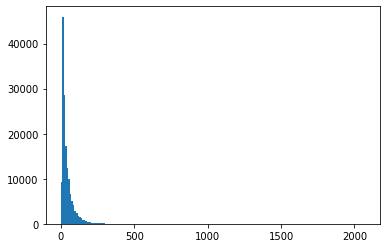

In [14]:
plt.hist(pos_length, bins=200);

Average Length of Negative Reviews:  44.11859326354394


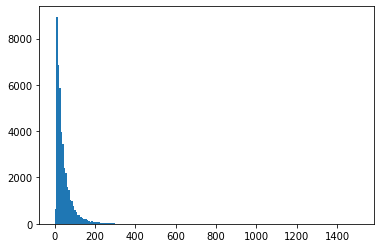

In [15]:
neg_reviews = df[df.pos_neg == 0]
neg_length = []
for review in neg_reviews.reviewText_tok:
    neg_length.append(len(review))
print('Average Length of Negative Reviews: ', np.mean(length))
plt.hist(neg_length, bins=200);

### Save Model 

In [16]:
# save the model file using pickle
def saveModel(model, name):
    path = "../Models/" + name
    pickle.dump(model, open(path,"wb"))

In [17]:
train_x, test_x, train_y, test_y = train_test_split(df.reviewText, df.pos_neg, random_state=42)

# Naive Bayes

In [18]:
print('Size of training set: ', len(train_x))
print('Size of test set: ', len(test_x))

Size of training set:  148876
Size of test set:  49626


### NB-Count Vectorizer

In [19]:
CV = CountVectorizer()
x_train_CV = CV.fit_transform(train_x)
x_test_CV = CV.transform(test_x)

In [20]:
NB_CV = MultinomialNB(alpha=1.6)
NB_CV.fit(x_train_CV, train_y)

MultinomialNB(alpha=1.6, class_prior=None, fit_prior=True)

### NB-Tfidf

In [21]:
tfidf = TfidfVectorizer()
x_train_tf = tfidf.fit_transform(train_x)
x_test_tf = tfidf.transform(test_x)

In [22]:
svd = TruncatedSVD()
svd.fit(x_train_tf)

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
             random_state=None, tol=0.0)

In [23]:
NB_tf = MultinomialNB(alpha=0.01)
NB_tf.fit(x_train_tf, train_y)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

### Accuracy

In [24]:
f1_tf = f1_score(test_y, NB_tf.predict(x_test_tf))
f1_CV = f1_score(test_y, NB_CV.predict(x_test_CV))
print('NB-CV ', f1_tf)
print('NB-TF ', f1_CV)

NB-CV  0.8883303327176226
NB-TF  0.9057295796986519


#### Save model

In [25]:
# serializing our model to a file called model.pkl
pickle.dump(NB_tf, open("../Models/model.pkl","wb"))
pickle.dump(NB_CV, open("../Models/model.pkl","wb"))

# Logistic Regression

### Tfidf

In [26]:
lr_tf = LogisticRegression()
lr_tf.fit(x_train_tf, train_y)

/Users/nithinsivakumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Count Vectorizer

In [27]:
lr_cv = LogisticRegression()
lr_cv.fit(x_train_CV, train_y)

/Users/nithinsivakumar/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
f1_lg_tf = lr_tf.score(x_test_tf, test_y)
f1_lg_cv = lr_cv.score(x_test_CV, test_y)
saveModel(lr_tf, "lr_tf.pkl")
saveModel(lr_cv, "lr_cv.pkl")

In [29]:
print('LR-CV ', f1_lg_tf)
print('LR-TF ', f1_lg_cv)

LR-CV  0.8681739410792729
LR-TF  0.860839076290654


# Predict a single review

In [46]:
# save train_x,y
with open("/Users/nithinsivakumar/projects/ubicomp/opinion-mining/Models/train.pkl", "wb") as f:
    pickle.dump([train_x, train_y], f)

In [50]:
with open("/Users/nithinsivakumar/projects/ubicomp/opinion-mining/Models/train.pkl", "rb") as f:
    train_a, train_b = pickle.load(f)

cvN=CountVectorizer()
a_train_CV = cvN.fit_transform(train_a)
content = "texture concealer pallet fantastic great cover."
data = [content]
vect = cvN.transform(data).toarray()
model = pickle.load(open("/Users/nithinsivakumar/projects/ubicomp/opinion-mining/Models/model.pkl", "rb"))
my_prediction = model.predict(vect)
my_prediction[0]

1